# KNN Recommenders
## DSC 672: Data Science Capstone
## Group 2: Anthony Anekwe, Ross Pollock, Nick Short

In [1]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [3]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 341kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1646979 sha256=aa706e8f591313f19b43780e51822dc8471c91200a5e14ab6a3e316c4dbfbb51
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


### Libraries

In [4]:
# Data Loading 
import numpy as np
import pandas as pd
import sqlite3 as sql
from surprise import Dataset, Reader

# Recommender Systems (KNN)
from surprise import KNNBasic, KNNBaseline
from surprise import KNNWithMeans, KNNWithZScore

# Model Selection
from sklearn.model_selection import train_test_split

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns 

# Default Dictionary
from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Loading

In [5]:
# Path to Database
db_path = '/drive/My Drive/DSC672_Project/datasets/climbing_full.sqlite'

# Load User Ratings
with sql.connect(db_path) as conn:
  ratings = pd.read_sql_query('''
    SELECT user_id, route_id, AVG(user_star) as rating
    FROM ticks
    WHERE user_star 
    BETWEEN 0 AND 4
    GROUP BY user_id, route_id;
  ''',conn)

In [6]:
# Read In Routes
route_csv = '/drive/My Drive/DSC672_Project/datasets/cleaned_routes.csv'
clean_routes = pd.read_csv(route_csv,index_col=0)

In [7]:
clean_routes.head()

,id,name,stars,star_votes,pitches,state,city,area,sub_area,micro_area,link,img_link,long,lat,YDSUSA,HuecoUSA,Safety,Trad,Sport,Boulder,TR
0,105714800,Garfield Goes To Washington,4.7,153,3.0,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,Emancipation,White House Wall,https://www.mountainproject.com/route/10571480...,https://cdn2.apstatic.com/photos/climb/1119963...,-103.4619,43.8807,13.0,NaN,NaN,1.0,0.0,0.0,0.0
1,105715100,Keystone Wise Crack (Right Fork),2.0,1,1.0,South Dakota,The Needles Of Rushmore,Iron Mountain,Rubiks Ridge,NaN,https://www.mountainproject.com/route/10571510...,https://cdn2.apstatic.com/photos/climb/1030070...,-103.4317,43.8731,32.0,NaN,1.0,1.0,0.0,0.0,0.0
2,105715400,Babob,2.8,11,1.0,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,Chopping Block,Veiny,https://www.mountainproject.com/route/10571540...,NaN,-103.4693,43.8864,24.0,NaN,NaN,0.0,1.0,0.0,1.0
3,105715700,Spacedust,3.4,5,1.0,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,Magna Carta,Marker,https://www.mountainproject.com/route/10571570...,https://cdn2.apstatic.com/photos/climb/1030007...,-103.4623,43.8824,16.0,NaN,1.0,0.0,1.0,0.0,0.0
4,105717400,Amaretto Corner,4.0,182,2.0,Utah,Moab Area,Indian Creek,Supercrack Buttress,NaN,https://www.mountainproject.com/route/10571740...,https://cdn2.apstatic.com/photos/climb/1060474...,-109.5455,38.0363,23.0,NaN,NaN,1.0,0.0,0.0,0.0


In [8]:
# Remove any Non-Clean Routes
ratings = ratings[ratings.route_id.isin(clean_routes.id.unique())]

In [9]:
ratings.head()

,user_id,route_id,rating
0,10101,105847227,4.0
2,10102,105717328,4.0
3,10102,105717346,2.0
4,10102,105717349,4.0
5,10102,105717367,4.0


## Utility Functions 

In [10]:
def rating_info(
    df:pd.DataFrame,
    uid_col:str = 'user_id',
    iid_col:str = 'route_id'
  ) -> None:
  '''
  Prints out simple info about ratings DataFrame
    - Total Number of Ratings
    - Number of Users
    - Number of Items
    - Sparsity of User Item Matrix
  '''
  n_users = len(df[uid_col].unique()) 
  n_items = len(df[iid_col].unique())
  n_rating = df.shape[0]

  sparsity = 1 - n_rating / (n_users * n_items)
  print(f'Number of Ratings: {df.shape[0]}')
  print(f'Number of Users: {n_users}')
  print(f'Number of Items: {n_items}')
  print(f'Sparsity: {sparsity:0.5f}')

def min_interactions(
    df : pd.DataFrame,
    n : int,
    uid_col : str = 'user_id',
    iid_col : str = 'route_id'  
  ) -> pd.DataFrame:
  '''
  Removes Items and Users with less than n ratings
  '''
  unique_uid = set(df[uid_col].value_counts(sort=False).loc[lambda x: x > n].index)
  unique_iid = set(df[iid_col].value_counts(sort=False).loc[lambda x: x > n].index)

  return df[df[uid_col].isin(unique_uid) & df[iid_col].isin(unique_iid)]

## Determine Size of Rating Table

In [11]:
rating_info(ratings)

Number of Ratings: 1509041
Number of Users: 43855
Number of Items: 117347
Sparsity: 0.99971


In [12]:
rating_info(min_interactions(ratings,25))

Number of Ratings: 860524
Number of Users: 10146
Number of Items: 13440
Sparsity: 0.99369


In [13]:
rating_subset = min_interactions(ratings,25)

In [14]:
route_ids = rating_subset.route_id.unique()

In [15]:
route_ids

array([105717289, 105717319, 105717322, ..., 112433791, 112433801,
       110534067])

## Train Test Split

In [16]:
train_ds, test_ds = train_test_split(rating_subset,test_size=0.2)
train_ds, val_ds  = train_test_split(train_ds,test_size=(1/8))

## Format Pandas DFs to Surprise Format

In [17]:
data_reader = Reader(rating_scale=(0,4))

train_ds = Dataset.load_from_df(train_ds,data_reader)

## Hyper Parameter and Model Search

In [18]:
def eval_val_set(model,ds):
  '''
  Evaluate Surpise Model
  Inputs:
    model: Surpise Model
    ds: pd.DataFrame - columns = uid | iid | rating
  Returns MAE, RMSE
  '''
  absolute_error = np.empty(len(ds))
  squared_error  = np.empty(len(ds))
  for idx, row in enumerate(ds.to_numpy()):
    uid, iid, rui = row  
    _,_,_,est,_ = model.predict(uid,iid)
    absolute_error[idx] = np.abs(rui-est)
    squared_error[idx]  = (rui-est)**2  
  return absolute_error.mean(), np.sqrt(squared_error.mean())
  

### Basic KNN

In [ ]:
params = {'k':[5,10,20,30,40],'sim':['msd','cosine','pearson']}

results = np.empty(shape=(len(params['k'])*len(params['sim']),4),dtype=object)
i = 0
for k in params['k']:
  for sim in params['sim']:
    model = KNNBasic(k=k,sim_options={'name':sim},verbose=0)
    model.fit(train_ds.build_full_trainset())
    mae, rmse = eval_val_set(model,val_ds)

    results[i] = [k,sim,mae,rmse]
    i = i+1

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:248: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


In [ ]:
results_df = pd.DataFrame(results)
results_df.columns = ['K','Similarity','MAE','RMSE']

In [ ]:
results_df = results_df.astype({'K':np.int,'MAE':np.float64,'RMSE':np.float64})

In [ ]:
print(results_df)

     K Similarity       MAE      RMSE
0    5        msd  0.512517  0.665559
1    5     cosine  0.532086  0.687809
2    5    pearson  0.530668  0.685965
3   10        msd  0.496668  0.638243
4   10     cosine  0.513037  0.657218
5   10    pearson  0.515814  0.661509
6   20        msd  0.491171  0.628194
7   20     cosine  0.503952  0.642590
8   20    pearson  0.509007  0.651163
9   30        msd  0.490904  0.627155
10  30     cosine  0.502021  0.639317
11  30    pearson  0.507394  0.648675
12  40        msd  0.491350  0.627244
13  40     cosine  0.501253  0.637955
14  40    pearson  0.506810  0.647859


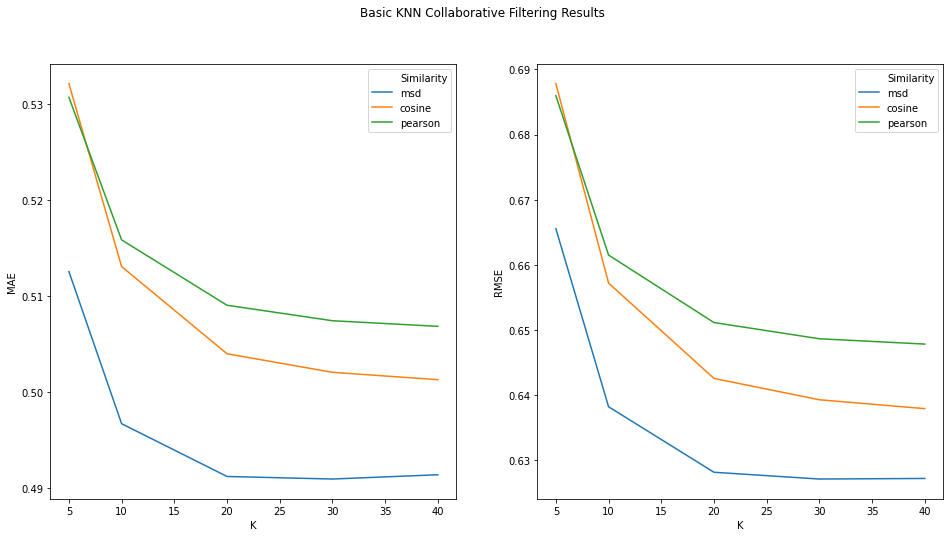

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(16,8))
sns.lineplot(x='K',y='MAE',hue='Similarity',data=results_df, ax=axs[0])
sns.lineplot(x='K',y='RMSE',hue='Similarity',data=results_df, ax=axs[1])
fig.suptitle('Basic KNN Collaborative Filtering Results')
plt.show()

In [ ]:
print('Min MAE')
print(results_df[results_df.MAE == results_df.MAE.min()])
print('Min RMSE')
print(results_df[results_df.RMSE == results_df.RMSE.min()])

Min MAE
    K Similarity       MAE      RMSE
9  30        msd  0.490904  0.627155
Min RMSE
    K Similarity       MAE      RMSE
9  30        msd  0.490904  0.627155


### KNN with Mean

In [ ]:
params = {'k':[5,10,20,30,40],'sim':['msd','cosine','pearson']}

results_knn_mean = np.empty(shape=(len(params['k'])*len(params['sim']),4),dtype=object)
i = 0
for k in params['k']:
  for sim in params['sim']:
    model = KNNWithMeans(k=k,sim_options={'name':sim},verbose=0)
    model.fit(train_ds.build_full_trainset())
    mae, rmse = eval_val_set(model,val_ds)

    results_knn_mean[i] = [k,sim,mae,rmse]
    i = i+1

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:248: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


In [ ]:
results_df = pd.DataFrame(results_knn_mean)
results_df.columns = ['K','Similarity','MAE','RMSE']

In [ ]:
results_df = results_df.astype({'K':np.int,'MAE':np.float64,'RMSE':np.float64})

In [ ]:
print(results_df)

     K Similarity       MAE      RMSE
0    5        msd  0.536582  0.686324
1    5     cosine  0.544888  0.696516
2    5    pearson  0.530460  0.683415
3   10        msd  0.513834  0.657076
4   10     cosine  0.520647  0.664768
5   10    pearson  0.509530  0.657246
6   20        msd  0.501544  0.642090
7   20     cosine  0.506749  0.647563
8   20    pearson  0.500389  0.645634
9   30        msd  0.497759  0.637796
10  30     cosine  0.501990  0.642205
11  30    pearson  0.497634  0.642304
12  40        msd  0.496024  0.635878
13  40     cosine  0.499734  0.639643
14  40    pearson  0.496443  0.640907


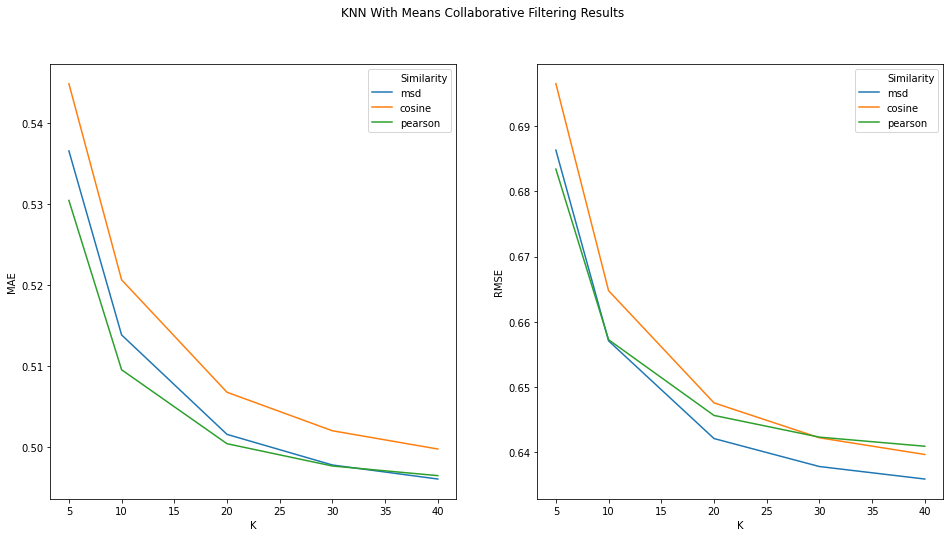

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(16,8))
sns.lineplot(x='K',y='MAE',hue='Similarity',data=results_df, ax=axs[0])
sns.lineplot(x='K',y='RMSE',hue='Similarity',data=results_df, ax=axs[1])
fig.suptitle('KNN With Means Collaborative Filtering Results')
plt.show()

In [ ]:
print('Min MAE')
print(results_df[results_df.MAE == results_df.MAE.min()])
print('Min RMSE')
print(results_df[results_df.RMSE == results_df.RMSE.min()])

Min MAE
     K Similarity       MAE      RMSE
12  40        msd  0.496024  0.635878
Min RMSE
     K Similarity       MAE      RMSE
12  40        msd  0.496024  0.635878


### KNN with Z-Score

In [ ]:
params = {'k':[5,10,20,30,40,50],'sim':['msd','cosine','pearson']}

results_knn_zs = np.empty(shape=(len(params['k'])*len(params['sim']),4),dtype=object)
i = 0
for k in params['k']:
  for sim in params['sim']:
    model = KNNWithZScore(k=k,sim_options={'name':sim},verbose=0)
    model.fit(train_ds.build_full_trainset())
    mae, rmse = eval_val_set(model,val_ds)

    results_knn_zs[i] = [k,sim,mae,rmse]
    i = i+1

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:248: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


In [ ]:
results_df = pd.DataFrame(results_knn_zs)
results_df.columns = ['K','Similarity','MAE','RMSE']
results_df = results_df.astype({'K':np.int,'MAE':np.float64,'RMSE':np.float64})
print(results_df)

     K Similarity       MAE      RMSE
0    5        msd  0.535653  0.687938
1    5     cosine  0.543937  0.698148
2    5    pearson  0.527486  0.681450
3   10        msd  0.511899  0.656334
4   10     cosine  0.518622  0.664049
5   10    pearson  0.506756  0.654593
6   20        msd  0.499100  0.640044
7   20     cosine  0.504154  0.645463
8   20    pearson  0.497376  0.642520
9   30        msd  0.495177  0.635490
10  30     cosine  0.499312  0.639714
11  30    pearson  0.494557  0.639115
12  40        msd  0.493402  0.633402
13  40     cosine  0.497023  0.636954
14  40    pearson  0.493399  0.637706
15  50        msd  0.492560  0.632603
16  50     cosine  0.495557  0.635499
17  50    pearson  0.492804  0.637016


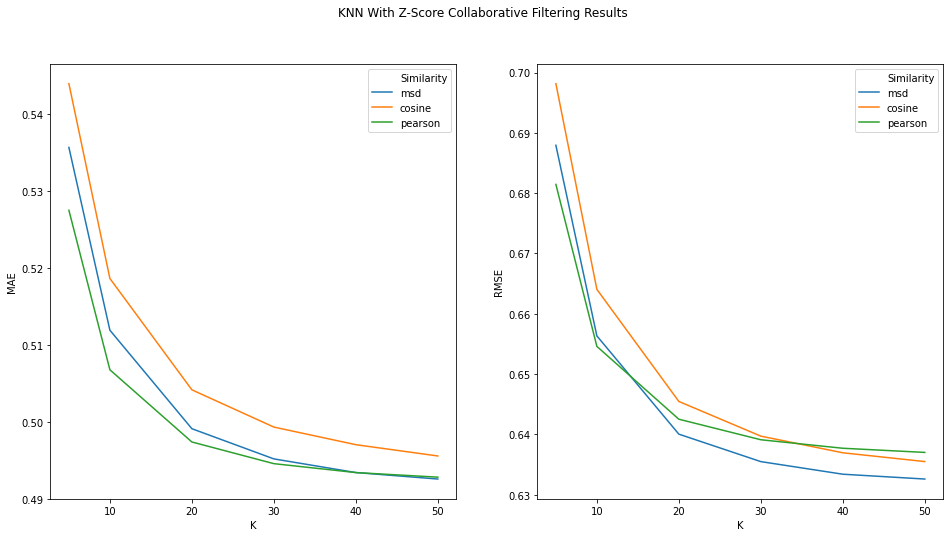

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(16,8))
sns.lineplot(x='K',y='MAE',hue='Similarity',data=results_df, ax=axs[0])
sns.lineplot(x='K',y='RMSE',hue='Similarity',data=results_df, ax=axs[1])
fig.suptitle('KNN With Z-Score Collaborative Filtering Results')
plt.show()

In [ ]:
print('Min MAE')
print(results_df[results_df.MAE == results_df.MAE.min()])
print('Min RMSE')
print(results_df[results_df.RMSE == results_df.RMSE.min()])

Min MAE
     K Similarity      MAE      RMSE
15  50        msd  0.49256  0.632603
Min RMSE
     K Similarity      MAE      RMSE
15  50        msd  0.49256  0.632603


## Test Set Score

In [19]:
def relevant_items(df,user_col,item_col,rate_col,threshold=2.5):
  '''
  Generates Users' Set of relevant items 
  where the explicit rating is greater than 
  the threshold which defaults to 2.5
  '''
  df = df[df[rate_col] > threshold]
  df = df.groupby(user_col).agg({item_col:lambda x: set(x)})
  return df 

In [20]:
def precision_recall_at_k(model,ds,item_set,k_vals=[1,5,10,25]):
  precision, recall = defaultdict(np.array), defaultdict(np.array)
  for k in k_vals:
    precision[k] = np.empty(len(ds))
    recall[k] = np.empty(len(ds))
  for pdx, uid in enumerate(ds.index):
    est_ratings = np.empty(len(item_set))
    for idx,iid in enumerate(item_set):
      _,_,_,est,_ = model.predict(uid,iid)
      est_ratings[idx] = est 
    top_k = np.argsort(est_ratings)[::-1][:max(k_vals)]
    for k in k_vals:
      top_k_prime = top_k[:k]
      top_k_prime = set(item_set[top_k_prime])
      rel = ds.loc[uid]['route_id'] 
      rel_and_rec = top_k_prime & rel
      precision[k][pdx] = len(rel_and_rec) / float(k)
      recall[k][pdx] = len(rel_and_rec) / float(len(rel)) if len(rel) > 0 else 0
  for k in k_vals:
    precision[k] = precision[k].mean() 
    recall[k] = recall[k].mean()
  return precision, recall
  

### Build Model with Best Parameters

In [21]:
final_knn_model = KNNBasic(k=30)
final_knn_model.fit(train_ds.build_full_trainset())

Computing the msd similarity matrix...
Done computing similarity matrix.


### MAE & RMSE

In [22]:
eval_val_set(final_knn_model,test_ds)

(0.4916149928196221, 0.6271527519071626)

### Precision & Recall @ k 

In [ ]:
# Build Test Dataset to Calculate Precision / Recall @ k 
test_ds = relevant_items(test_ds,'user_id','route_id','rating')

In [ ]:
test_ds.head()

,route_id
user_id,
10106,"{105758080, 105761538, 106447491, 105749125, 1..."
10116,"{105789316, 105721627, 106070940, 106505501, 1..."
10118,"{105749065, 105748657, 105861268, 105886456}"
10121,"{105717376, 105749890, 105761538, 105748612, 1..."
10123,"{107068739, 105988542, 105975428, 105749785, 1..."


In [ ]:
%%time
precision, recall = precision_recall_at_k(
    final_knn_model,test_ds,route_ids,
    k_vals=[1,5,10,25]
)

CPU times: user 2h 20min 53s, sys: 1.22 s, total: 2h 20min 55s
Wall time: 2h 21min 3s


In [ ]:
precision

defaultdict(<function numpy.array>,
            {1: 0.0002050440844781628,
             5: 0.0006356366618823048,
             10: 0.000574123436538856,
             25: 0.0005659216731597294})

In [ ]:
recall

defaultdict(<function numpy.array>,
            {1: 8.417863762277518e-06,
             5: 0.00022642068031596886,
             10: 0.00032815488371800214,
             25: 0.0007768510411615845})

## Save KNN Model

In [ ]:
from surprise.dump import dump
recommender_path = '/drive/My Drive/DSC672_Project/Recommenders/'
dump(file_name=recommender_path + 'knn_recommender.pickle',
     algo=final_knn_model)